# JPX Tokyo Stock Exchange Prediction Challenge

## Time Series Analysis

Authors: Jeremy Jang (jj2798), Kevin Lee (kl3642), Kevin Zheng (kz1252)

## 1. Preliminary EDA and Data Engineering

Necessary Packages

In [1]:
# If you need missingno

#!pip install missingno

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import copy 
#need to import all of the relevant sklearn stuff and corr/arma models
from statsmodels.tsa.statespace.sarimax import SARIMAX

First we load the data into the variable `df`.

In [3]:
df = pd.read_csv('stock_prices.csv', parse_dates=['Date'],index_col='Date')
df.index = pd.DatetimeIndex(df.index).to_period('D')


In [4]:
df.head()

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


Now let's take a look at each feature and the target...

In [5]:
print(df.info())

print('\nUnique Securities:')
print(df.SecuritiesCode.unique())
print('Num unique: ',len(df.SecuritiesCode.unique()))
print('AKA 2000 total tickers')

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2332531 entries, 2017-01-04 to 2021-12-03
Freq: D
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   RowId             object 
 1   SecuritiesCode    int64  
 2   Open              float64
 3   High              float64
 4   Low               float64
 5   Close             float64
 6   Volume            int64  
 7   AdjustmentFactor  float64
 8   ExpectedDividend  float64
 9   SupervisionFlag   bool   
 10  Target            float64
dtypes: bool(1), float64(7), int64(2), object(1)
memory usage: 198.0+ MB
None

Unique Securities:
[1301 1332 1333 ... 4168 7342 4169]
Num unique:  2000
AKA 2000 total tickers


In [6]:
print(df.describe())

       SecuritiesCode          Open          High           Low         Close  \
count    2.332531e+06  2.324923e+06  2.324923e+06  2.324923e+06  2.324923e+06   
mean     5.894835e+03  2.594511e+03  2.626540e+03  2.561227e+03  2.594023e+03   
std      2.404161e+03  3.577192e+03  3.619363e+03  3.533494e+03  3.576538e+03   
min      1.301000e+03  1.400000e+01  1.500000e+01  1.300000e+01  1.400000e+01   
25%      3.891000e+03  1.022000e+03  1.035000e+03  1.009000e+03  1.022000e+03   
50%      6.238000e+03  1.812000e+03  1.834000e+03  1.790000e+03  1.811000e+03   
75%      7.965000e+03  3.030000e+03  3.070000e+03  2.995000e+03  3.030000e+03   
max      9.997000e+03  1.099500e+05  1.105000e+05  1.072000e+05  1.095500e+05   

             Volume  AdjustmentFactor  ExpectedDividend        Target  
count  2.332531e+06      2.332531e+06      18865.000000  2.332293e+06  
mean   6.919366e+05      1.000508e+00         22.017730  4.450964e-04  
std    3.911256e+06      6.773040e-02         29.88245

And how many NaN values there are...

In [7]:
print('\nNaN Values:')
print(df.isnull().sum())
print('\nTotal NaN: ',df.isnull().sum().sum())


NaN Values:
RowId                     0
SecuritiesCode            0
Open                   7608
High                   7608
Low                    7608
Close                  7608
Volume                    0
AdjustmentFactor          0
ExpectedDividend    2313666
SupervisionFlag           0
Target                  238
dtype: int64

Total NaN:  2344336


<AxesSubplot:>

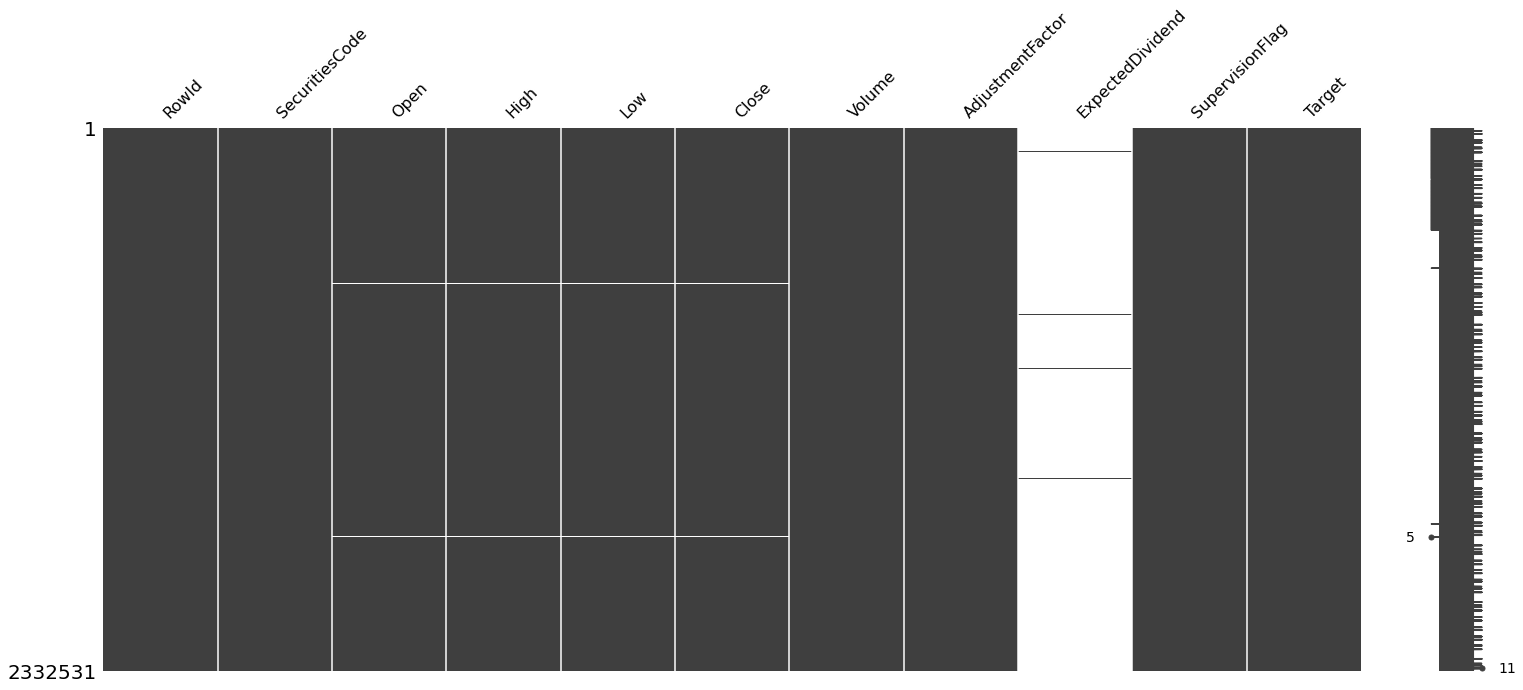

In [8]:
msno.matrix(df)

We can see that there are quite a few missing value, namely from the features `[Open, High, Low, Close, ExpectedDividend, Target]`. The competition provides us with a file that contains the descriptions for each feature in our dataset.

In [9]:
spec = pd.read_csv('stock_price_spec.csv')

In [10]:
spec

,Column,Sample value,Type,Addendum,Remarks
0,RowId,20170104_1301,string,NaN,Unique ID of price records
1,Date,2017-01-04 0:00:00,date,NaN,Trade date
2,SecuritiesCode,1301,Int64,NaN,Local securities code
3,Open,2734,float,NaN,first traded price on a day
4,High,2755,float,NaN,highest traded price on a day
5,Low,2730,float,NaN,lowest traded price on a day
6,Close,2742,float,NaN,last traded price on a day
7,Volume,31400,Int64,NaN,number of traded stocks on a day
8,AdjustmentFactor,1,float,NaN,to calculate theoretical price/volume when spl...
9,SupervisionFlag,FALSE,boolean,NaN,Flag of Securities Under Supervision & Securit...


From this information, we can understand that we will not be needing the following features: `[RowId, SupervisionFlag, ExpectedDividend, Target]`. We will need the SecurityCode to pick the stocks to analyze. Our analysis will be chiefly concerned with the date and the close adjusted price of the stocks, so we can disregard `[Open, High, Low]` as well. We have also already determined that the Volume is weakly correlated at best with the close price, so we will also be discarding that feature. The adjustment factor is required to compute the close adjusted price.

In [11]:
# Drop unnecessary columns
df.drop(columns=['RowId','Open','High','Low','Volume','SupervisionFlag','ExpectedDividend','Target'],inplace=True)
df

,SecuritiesCode,Close,AdjustmentFactor
Date,,,
2017-01-04,1301,2742.0,1.0
2017-01-04,1332,571.0,1.0
2017-01-04,1333,3210.0,1.0
2017-01-04,1376,1550.0,1.0
2017-01-04,1377,3330.0,1.0
...,...,...,...
2021-12-03,9990,528.0,1.0
2021-12-03,9991,794.0,1.0
2021-12-03,9993,1645.0,1.0


In [12]:
# Compute Close Adjusted Price
df['close_adj'] = df['Close'] / df['AdjustmentFactor']
df

,SecuritiesCode,Close,AdjustmentFactor,close_adj
Date,,,,
2017-01-04,1301,2742.0,1.0,2742.0
2017-01-04,1332,571.0,1.0,571.0
2017-01-04,1333,3210.0,1.0,3210.0
2017-01-04,1376,1550.0,1.0,1550.0
2017-01-04,1377,3330.0,1.0,3330.0
...,...,...,...,...
2021-12-03,9990,528.0,1.0,528.0
2021-12-03,9991,794.0,1.0,794.0
2021-12-03,9993,1645.0,1.0,1645.0


In [13]:
df.drop(columns=['Close','AdjustmentFactor'],inplace=True)
df

,SecuritiesCode,close_adj
Date,,
2017-01-04,1301,2742.0
2017-01-04,1332,571.0
2017-01-04,1333,3210.0
2017-01-04,1376,1550.0
2017-01-04,1377,3330.0
...,...,...
2021-12-03,9990,528.0
2021-12-03,9991,794.0
2021-12-03,9993,1645.0


Before we select the stocks to use, we cannot forget about the missing values. There are still 7608 missing entries for `[Open, High, Low, Close]`. Looking back at the matrix of missing values, we can observe that the missing values all occur on the same two instances. Based on this information, we can conclude that there must have been two separate instances in which the stock market failed to report the prices. Considering it does not make sense to impute prices for the analysis, we will drop the NaN values.

In [14]:
df.dropna(inplace=True)
df.isnull().sum()

SecuritiesCode    0
close_adj         0
dtype: int64

Now we need to select the stocks to use in our analysis. We decided to choose stocks that reflect different behaviors (bull, bear, neutral). A "bullish" stock is one that experiences a prolonged period of rising stock prices (typically 20% or more over at least 2 months). A "bearish" stock is one that performs the opposite. A "neutral" or "sideways" stock is one whos prices appear to settle at a mean over a prolonged period of time.

Based on these criteria, we decided to use the securities: `[7309,7287,7282]`.

In [15]:
sample_stocks = [7309, 7287, 7282]

Now that we have chosen the stocks to predict on, we can start on some preliminary data analysis. To start, we will plot the close adjusted price over time for each of the stocks chosen to observe any obvious patterns.

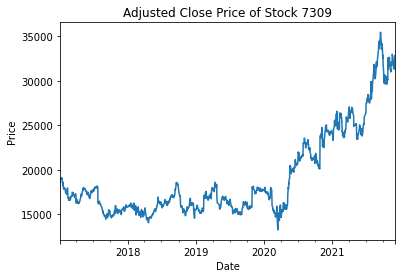

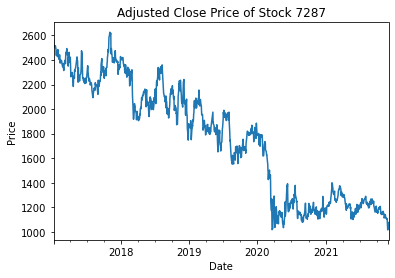

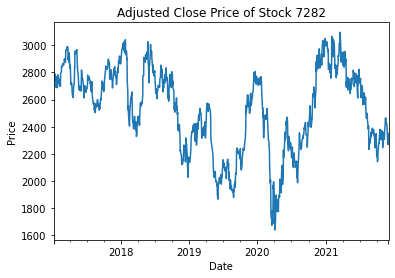

In [16]:
for sample_stock in sample_stocks:
    df[df["SecuritiesCode"] == sample_stock]["close_adj"].plot()
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.title("Adjusted Close Price of Stock {}".format(sample_stock))
    plt.show()

The stocks chosen appear to respectively reflect the different trends defined above. However, to use the SARIMAX model, the data must be stationary. To test stationarity, we will use the adfuller test to calculate the p-value of each stock against a threshold of p=0.05

In [17]:
from statsmodels.tsa.stattools import adfuller
for sample_stock in sample_stocks:
      result = adfuller(df[(df["SecuritiesCode"] == sample_stock)]["close_adj"])
      print("p-value for stock {}: {}\n".format(sample_stock,result[1])) 

        


p-value for stock 7309: 0.9753507669820672

p-value for stock 7287: 0.5279018137455542

p-value for stock 7282: 0.08785546983486275



The null hypothesis for the Augmented Dickey-Fuller test is that the data is non-stationary. Since the p-values for each stock chosen is above the threshold of 0.05, we are unable to reject the null hypothesis. This indicates that we need to modify the data to make it stationary. In this case, we take the first difference of the data and run the adfuller test again. 

ADF statistic of first diff of stock 7309 -35.20846444911144
p-value for first diff of stock 7309 0.0


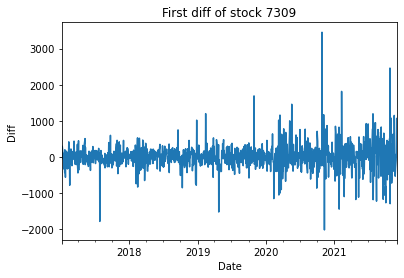

ADF statistic of first diff of stock 7287 -35.73564949218955
p-value for first diff of stock 7287 0.0


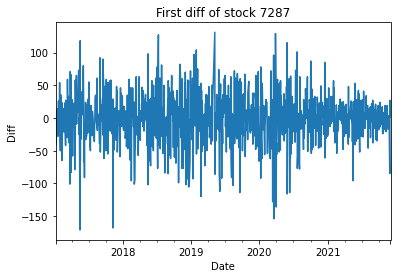

ADF statistic of first diff of stock 7282 -34.43174345364977
p-value for first diff of stock 7282 0.0


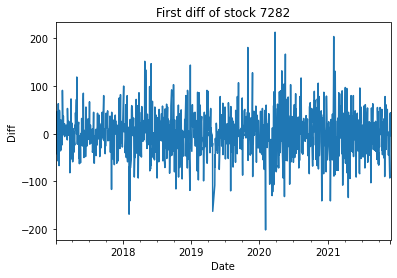

In [18]:
#First Diff
for sample_stock in sample_stocks:
    df_sample = df[(df["SecuritiesCode"] == sample_stock)]["close_adj"].diff().dropna()
    result = adfuller(df_sample)
    print("ADF statistic of first diff of stock {}".format(sample_stock), result[0])
    print("p-value for first diff of stock {}".format(sample_stock), result[1])
    df_sample.plot()
    plt.title("First diff of stock {}".format(sample_stock))
    plt.ylabel("Diff")
    plt.xlabel("Date")
    plt.show()

Running the adfuller test against the first difference, we get a p-value of 0.0 for each stock with a test statistic ~-35.
The low p-value indicates that we are able to reject the null hypothesis that the data is non-stationary, meaning we can use
the first difference to make our data stationary. 

In [19]:
df_7309 = df[(df["SecuritiesCode"] == 7309)]["close_adj"]
df_7287 = df[(df["SecuritiesCode"] == 7287)]["close_adj"]
df_7282 = df[(df["SecuritiesCode"] == 7282)]["close_adj"]


Figuring out hyperparams and how many times to take diff

Remember: SARIMAX will be set to have an order (p,1,q). We should leave the differencing to the model.

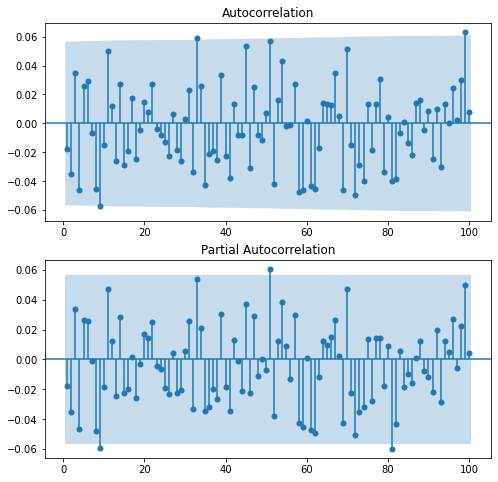

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,8))

plot_acf(df_7309.diff().dropna(),lags=100, zero = False, ax=ax1)

plot_pacf(df_7309.diff().dropna(),lags=100,zero = False, ax=ax2,method='ywm')

plt.show()

In [21]:
df_7309_s = df_7309.diff().dropna()

Before we run SARIMAX, we'll create a function to perform the gridsearch using various p, q values to find the optimal (p,0,q) for our SARIMAX model. 

* p -- AR (Auto Regressive) order
* q -- MA (Moving Average) order

In [22]:
import pmdarima as pm
model1 = pm.auto_arima(df_7309,
                      seasonal = True, m=7,
                      d= 1, D=1,
                      max_p=3, max_q=3,
                      trace = True,
                      error_action="ignore",
                      suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=inf, Time=11.52 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=18255.851, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=17898.834, Time=0.98 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.72 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=18257.766, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=17769.772, Time=1.74 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.12 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.36 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=17768.165, Time=0.44 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=17896.929, Time=0.32 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=17769.759, Time=1.62 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=5.79 sec
 ARIMA(0,1,0)(2,1,0)[7] intercept   : AIC=17770.013, Time=2.

In [39]:
def reindex_and_separate(df, start):
    new_index = pd.period_range(df.index[0], df.index[-1], freq=df.index.freq)
    df = df.reindex(new_index)
    df.ffill(inplace= True)
    df_r = df.iloc[:-1*start+1]
    df_t = df.tail(start)
    return df_r, df_t


In [40]:
df_7309, df_7309_f = reindex_and_separate(df_7309, 183)
df_7287, df_7287_f = reindex_and_separate(df_7287, 183)
df_7282, df_7282_f = reindex_and_separate(df_7282, 183)

In [41]:
print(df_7309.tail())
print(df_7309_f.head())

2020-11-29    24885.0
2020-11-30    24740.0
2020-12-01    25050.0
2020-12-02    24495.0
2020-12-03    24255.0
Freq: D, Name: close_adj, dtype: float64
2020-12-03    24255.0
2020-12-04    24395.0
2020-12-05    24395.0
2020-12-06    24395.0
2020-12-07    24400.0
Freq: D, Name: close_adj, dtype: float64


In [42]:
def create_model(df, p, q):
    model = SARIMAX(df, order = (p,1,q), trend = "ct")
    results = model.fit()
    return results

In [43]:
results_7309 = create_model(df_7309, 0, 0)
results_7287 = create_model(df_7287, 1, 3)
results_7282 = create_model(df_7282, 0, 0)


In [50]:
def plot_data(df, df_t, results, steps, stock_name):
    forecast = results.get_forecast(steps = steps)
    mean = forecast.predicted_mean
    conf_int = forecast.conf_int()
    
    dates = mean.index
    
    df.tail(100).plot(label = "past")
    plt.plot(dates,mean, label = "forecast")
    df_t.head(steps).plot(label = "true")
    plt.plot()
    
    plt.fill_between(dates, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha = 0.5)
    plt.legend()
    plt.xlabel("Date")
    plt.ylabel("Adjusted Close Price")
    plt.title("Forecasted Adjusted Close Price vs. True: {}".format(stock_name))
    plt.show()
    
    

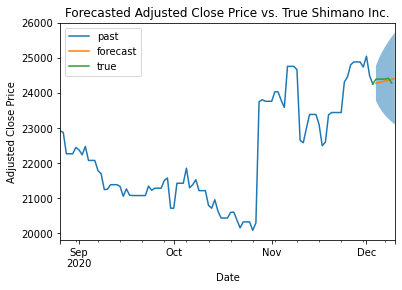

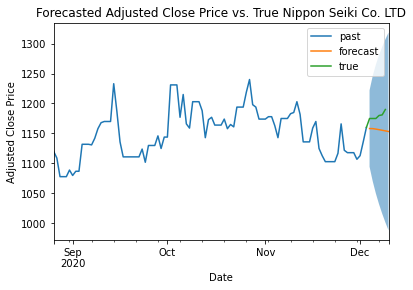

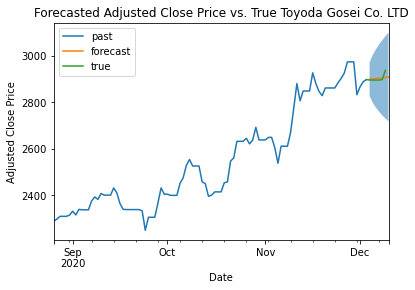

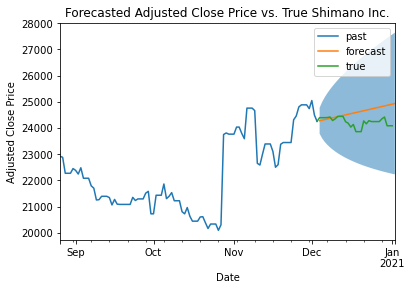

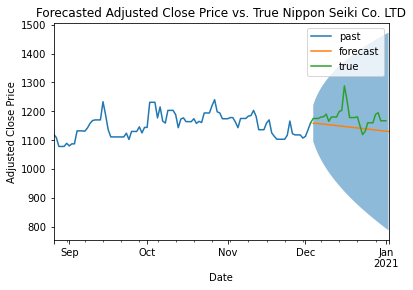

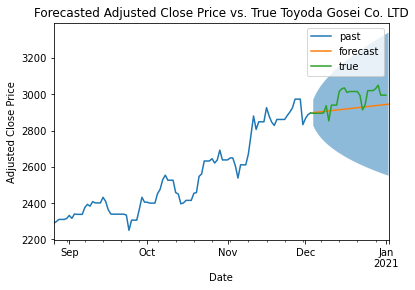

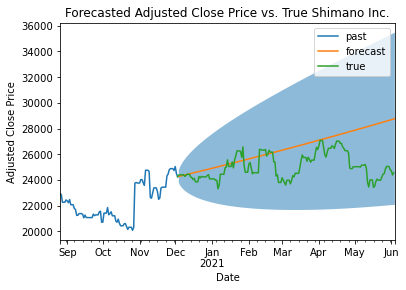

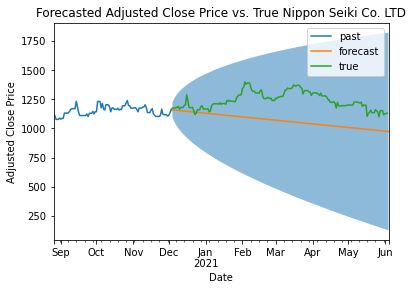

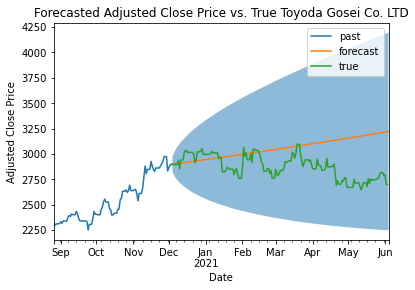

In [53]:
plot_data(df_7309, df_7309_f, results_7309, 7, "Shimano Inc.")
plot_data(df_7287, df_7287_f, results_7287, 7, "Nippon Seiki Co. LTD")
plot_data(df_7282, df_7282_f, results_7282, 7, "Toyoda Gosei Co. LTD")
plot_data(df_7309, df_7309_f, results_7309, 30, "Shimano Inc.")
plot_data(df_7287, df_7287_f, results_7287, 30, "Nippon Seiki Co. LTD")
plot_data(df_7282, df_7282_f, results_7282, 30, "Toyoda Gosei Co. LTD")
plot_data(df_7309, df_7309_f, results_7309, 183, "Shimano Inc.")
plot_data(df_7287, df_7287_f, results_7287, 183, "Nippon Seiki Co. LTD")
plot_data(df_7282, df_7282_f, results_7282, 183, "Toyoda Gosei Co. LTD")